In [154]:
import numpy as np
import pandas as pd
import os
import time
import schedule
import joblib
import datetime 
import multiprocessing as mp
from get_strategy_meta import get_all_strategy_meta
from query_api import get_path_dict, gen_connection, load_item_by_key, query_mysql
from get_signal_mongo import write_signal_mongo, get_signal_mongo
from get_signal_mysql import write_signal, get_signal
from mongo_functions import get_portfolio_db

from mongo_datetime import dtnow, dt, get_collection
from bson.codec_options import CodecOptions
import pytz
from bson.objectid import ObjectId 

# Check Log

In [156]:
db_name = "MLLog"
coll_name = "log"
db = get_portfolio_db(db_name)
coll = get_collection(db, coll_name)
# r = coll.find({"code":"W006", "key":"s_AUDUSD"})
# r = coll.find({"code": "X004", "key": "s_TLT"})
cond = {"idd.code": "Z001", "idd.key":"b_XAGUSD"}
# cond = {}
r = coll.find(cond)
df = pd.DataFrame([j for j in r])
# df.sort_values("time")
df.tail(150)

,Date,_id,idd,message,other
203851,2019-07-21 20:22:02.160000-04:00,5d3501aa0af2500931c310c3,"{'code': 'Z001', 'key': 'b_XAGUSD'}",Using Mongo: 2019-07-17 20:20:00-04:00 - 2019-...,
203852,2019-07-21 20:22:11.890000-04:00,5d3501b30af2500931c310c5,"{'code': 'Z001', 'key': 'b_XAGUSD'}",Scaling: Done!,
203853,2019-07-21 20:22:11.892000-04:00,5d3501b30af2500931c310c6,"{'code': 'Z001', 'key': 'b_XAGUSD'}",TimeseriesGenerator: Done!,
203854,2019-07-21 20:22:15.624000-04:00,5d3501b70af2500931c310c7,"{'code': 'Z001', 'key': 'b_XAGUSD'}",Model Loaded!,
203855,2019-07-21 20:22:16.531000-04:00,5d3501b80af2500931c310c8,"{'code': 'Z001', 'key': 'b_XAGUSD'}",Predict: Done!,
203856,2019-07-21 20:22:16.532000-04:00,5d3501b80af2500931c310c9,"{'code': 'Z001', 'key': 'b_XAGUSD'}",b_XAGUSD,"{'last_date': 2019-07-21 20:20:00-04:00, 'quer..."
203857,2019-07-21 20:24:51.841000-04:00,5d3502533156388fedc310c1,"{'code': 'Z001', 'key': 'b_XAGUSD'}","Loaded: scaler, DATA_PARAMS, MODEL_PARAMS, model.",
203858,2019-07-21 20:24:51.861000-04:00,5d3502533156388fedc310c2,"{'code': 'Z001', 'key': 'b_XAGUSD'}",Loaded: MINUTE_INDEX for XAGUSD,
203859,2019-07-21 20:24:51.862000-04:00,5d3502533156388fedc310c3,"{'code': 'Z001', 'key': 'b_XAGUSD'}",Using Mongo: 2019-07-17 20:20:00-04:00 - 2019-...,
203860,2019-07-21 20:24:57.694000-04:00,5d3502591e4f67271c3ccd94,"{'code': 'Z001', 'key': 'b_XAGUSD'}","Loaded: scaler, DATA_PARAMS, MODEL_PARAMS, model.",


# Check Signal

,_id,code,key,query_date,status,status_code,timeframe,write_time,y
last_date,,,,,,,,,
2019-07-21 20:40:00-04:00,5d35061276300a11d0385f3b,Z001,b_XAGUSD,2019-07-21 20:40:00-04:00,Successful.,1,5,2019-07-21 20:40:50.222000-04:00,0.298424
2019-07-21 20:45:00-04:00,5d35073ebaf53081f2a28cbc,Z001,b_XAGUSD,2019-07-21 20:45:00-04:00,Successful.,1,5,2019-07-21 20:45:50.177000-04:00,0.288032
2019-07-21 20:50:00-04:00,5d35086a788d048497706664,Z001,b_XAGUSD,2019-07-21 20:50:00-04:00,Successful.,1,5,2019-07-21 20:50:50.056000-04:00,0.276942
2019-07-21 20:55:00-04:00,5d350995ed84ac9ef3278ba9,Z001,b_XAGUSD,2019-07-21 20:55:00-04:00,Successful.,1,5,2019-07-21 20:55:49.662000-04:00,0.271373
2019-07-21 21:00:00-04:00,5d350ac1a5c4d74d24bc7169,Z001,b_XAGUSD,2019-07-21 21:00:00-04:00,Successful.,1,5,2019-07-21 21:00:49.926000-04:00,0.259060


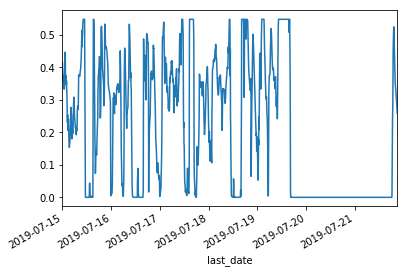

In [170]:


db_name = "MLProduction"
coll_name = "SignalOneLive3"
db = get_portfolio_db(db_name)
coll = get_collection(db, coll_name)

dd = dt(2019,7,15,0,0,0)
cond = {"code": "Z001", "key": "b_XAGUSD", "last_date": {"$gte":dd}}
r = coll.find(cond)
df = pd.DataFrame([j for j in r])
df = df.set_index("last_date")
df.y.plot()

df.tail()


In [ ]:
# df2["yshort"] = (df2["y"] >= 0.5) & (df["y"] < 0.5)
# df2["ylong"] = (df2["y"] < 0.5) & (df["y"] >= 0.5)

In [171]:
# df2[df2["yshort"] > 0]

In [172]:
# df.loc[df.y > 0.5]

## Check Lag


In [177]:


db_name = "MLProduction"
coll_name = "SignalOneLive3"
db = get_portfolio_db(db_name)
coll = get_collection(db, coll_name)

r = coll.find()
df = pd.DataFrame([j for j in r])
df = df.set_index("last_date")





In [181]:
df["d"] = df["write_time"] - df["query_date"]

In [195]:
df["d"] = df["d"].apply(lambda x: x.total_seconds()/60)

In [202]:
df["lag"] = df["d"] > df["timeframe"]
df[df["lag"]]

,_id,code,key,query_date,status,status_code,timeframe,write_time,y,d,lag
last_date,,,,,,,,,,,
2019-07-15 00:15:00-04:00,5d2bfefc6edb512b36223456,Z_C007,s_XAUUSD,2019-07-15 00:15:00-04:00,Successful.,1,5,2019-07-15 00:20:12.536000-04:00,4.319531e-01,5.208933,True
2019-07-15 00:15:00-04:00,5d2bfefcb3bfd340018d2ec6,Z001,b_XAGUSD,2019-07-15 00:15:00-04:00,Successful.,1,5,2019-07-15 00:20:12.789000-04:00,3.666598e-01,5.213150,True
2019-07-15 00:15:00-04:00,5d2bfefd03e57871348c6f0b,Z001,s_XAGUSD,2019-07-15 00:15:00-04:00,Successful.,1,5,2019-07-15 00:20:13.035000-04:00,7.813109e-08,5.217250,True
2019-07-15 00:15:00-04:00,5d2bff15a84a72d657ef3ec4,Z007,b_XAGUSD,2019-07-15 00:15:00-04:00,Successful.,1,5,2019-07-15 00:20:37.296000-04:00,5.051321e-01,5.621600,True
2019-07-15 00:15:00-04:00,5d2bff151f120aaea337d8ac,Z007,b_NZDUSD,2019-07-15 00:15:00-04:00,Successful.,1,5,2019-07-15 00:20:37.297000-04:00,1.277583e-01,5.621617,True
2019-07-15 00:15:00-04:00,5d2bff2dd4568c9a8ba15248,Z007,s_NZDUSD,2019-07-15 00:15:00-04:00,Successful.,1,5,2019-07-15 00:21:01.046000-04:00,7.722025e-01,6.017433,True
2019-07-15 00:15:00-04:00,5d2bff2de407b6d203725c1d,Z007,s_XAGUSD,2019-07-15 00:15:00-04:00,Successful.,1,5,2019-07-15 00:21:01.227000-04:00,5.535597e-02,6.020450,True
2019-07-15 01:15:00-04:00,5d2c0d0cbd41d3cc4438b0c6,Z001,s_XAGUSD,2019-07-15 01:15:00-04:00,Successful.,1,5,2019-07-15 01:20:12.624000-04:00,5.326867e-03,5.210400,True
2019-07-15 01:15:00-04:00,5d2c0d0ce4ac229de2dc2f4b,Z001,b_XAGUSD,2019-07-15 01:15:00-04:00,Successful.,1,5,2019-07-15 01:20:12.653000-04:00,4.461378e-01,5.210883,True


In [174]:
datetime.datetime.utcnow()

datetime.datetime(2019, 7, 22, 1, 3, 59, 22712)

In [175]:

db_name = "Production"
coll_name = "prices"
db = get_portfolio_db(db_name)
aware_times = db[coll_name]
result = aware_times.find()
pd.DataFrame([j for j in result]).tail()

,_id,name,price,time
853275,5d350b6331353b0340080895,USDMXN,19.02996,2019-07-22 01:03:00
853276,5d350b7731353b0340080896,ZB 09-19,154.71875,2019-07-22 00:53:00
853277,5d350b9a31353b0340080898,EURUSD,1.12094,2019-07-22 01:04:00
853278,5d350b9a31353b0340080899,USDJPY,107.96000,2019-07-22 01:04:00
853279,5d350b9b31353b034008089c,USDCAD,1.30666,2019-07-22 01:04:00


In [ ]:
datetime.datetime.now()

In [ ]:
datetime.datetime.utcnow()

In [ ]:
initial_tz='UTC'
converted_tz='US/Eastern'
# df["last_date"] = df["last_date"].dt.tz_localize(initial_tz)
df["last_date"] = df["last_date"].dt.tz_convert(converted_tz)     

In [ ]:
from bson.objectid import ObjectId 

db_name = "MLProduction"
coll_name = "SignalOneLive2"
db = get_portfolio_db(db_name)
coll = db[coll_name]
cond = {"_id": ObjectId("5d27d84706a26bddba27eb7e")}
# cond = {"code": "Z001", "key": "b_XAGUSD"}
r = coll.find(cond)
df = collection_to_df(r, ["last_date","query_date", "write_time"])
df.tail(10)



In [ ]:

df = df.drop(columns = ["_id"], axis = 1)
db_name = "MLProduction"
coll_name = "SignalOneLive2"
db = get_portfolio_db(db_name)
coll = db["testingdate"]
d_nonadj = df.to_dict(orient= "records")


In [ ]:
r = coll.find()
df = collection_to_df(r, ["last_date","query_date", "write_time"])
df.tail(10)

In [ ]:
r = coll.find()
df = pd.DataFrame([j for j in r])
df

In [ ]:

coll.insert_many(d_nonadj)

In [ ]:
db_name = "MLProduction"
coll_name = "SignalOneLive2"
db = get_portfolio_db(db_name)
coll = db[coll_name]
# r = coll.find({"code":"W006", "key":"s_AUDUSD"})
# r = coll.find({"code": "X004", "key": "s_TLT"})
cond = {"code": "Y001"}
cond = {"code": "W006", "key": "b_USDCAD"}
cond = {}
r = coll.find(cond)
df = pd.DataFrame([j for j in r])
# df.tail(10)
df["dd"] = [j.total_seconds()/60 for j in (df["write_time"] - df["query_date"])]
print(df.shape)
df.sort_values(["dd", "timeframe"], ascending = False)
df.sort_values(["code","key"], ascending = True)

In [ ]:
# df.set_index("query_date")["y"].plot()

# Check prices

@XAGUSD 48 days 02:55:00
@XAUUSD 48 days 02:55:00
ACWX 45 days 06:25:00
AGG 45 days 06:15:00
ASHR 45 days 06:27:00
AUDUSD 48 days 03:55:00
DBA 45 days 06:27:00
DBC 45 days 06:15:00
DIA 45 days 06:15:00
EEM 45 days 06:27:00
EFA 45 days 06:27:00
EMB 45 days 06:27:00
EURGBP 48 days 03:55:00
EURJPY 48 days 03:55:00
EURUSD 48 days 04:06:00
EWC 45 days 06:15:00
EWG 45 days 06:15:00
EWH 45 days 06:15:00
EWJ 45 days 06:27:00
EWT 45 days 06:15:00
EWW 45 days 06:15:00
EWY 45 days 06:15:00
EWZ 45 days 06:15:00
EZU 45 days 06:27:00
FEZ 45 days 06:15:00
FXI 45 days 06:27:00
GBPUSD 48 days 03:55:00
GDX 45 days 06:27:00
GDXJ 45 days 06:27:00
GLD 45 days 06:27:00
HYG 45 days 06:15:00
IAU 45 days 06:15:00
IBB 45 days 06:15:00
IEF 45 days 06:27:00
ITB 45 days 06:15:00
IWM 45 days 06:27:00
IYR 45 days 06:27:00
JNK 45 days 06:27:00
KRE 45 days 06:15:00
LQD 45 days 06:15:00
NZDUSD 48 days 03:55:00
OIH 45 days 06:15:00
PFF 45 days 06:27:00
QQQ 45 days 06:27:00
ROBO 45 days 06:23:00
RSX 45 days 06:15:00
RWX 

''

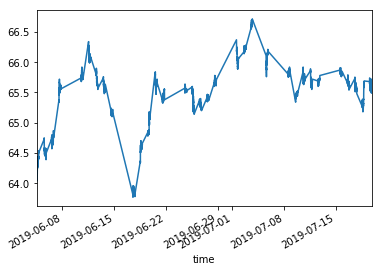

In [176]:
# %%time
db_name = "Production"
coll_name = "prices"
db = get_portfolio_db(db_name)
coll = db[coll_name]
name_list = coll.distinct("name")
r = coll.find({"name": "EFA"})
df = pd.DataFrame([j for j in r])
df = df.set_index("time")
df.index.is_monotonic_increasing
df.head()
df.tail()
df["price"].plot()
dp_list = []
for name in name_list:
    r = coll.find({"name": name})
    df = pd.DataFrame([j for j in r])
    df = df.set_index("time")
    print(name, df.index.max()- df.index.min())
    if df.index.duplicated().any():
        dp_list.append(name)
    
print(len(name_list))
",".join(dp_list)

In [ ]:
my_date = datetime.datetime.now(pytz.timezone('US/Eastern'))
# my_date = datetime.datetime.now()
my_date

In [ ]:
my_date = datetime.datetime(2019,7,12,2,30,0, tzinfo = pytz.timezone('US/Eastern'))

In [ ]:
db_name = "Production"
coll_name = "prices"
db = get_portfolio_db(db_name)
coll = db[coll_name]
r = coll.find({"name": "NZDUSD", "time":{"$lte": my_date}})
# r = coll.find({"name": "NZDUSD"})
pdf = pd.DataFrame([j for j in r])
pdf.tail()
# pdf = pdf.set_index("time")
# d = pdf.index[pdf.index.duplicated()]
# pdf.loc[d]



In [ ]:
my_date = datetime.datetime.now(pytz.timezone('US/Pacific'))
my_date

In [ ]:
import pytz
my_date = datetime.datetime.now(pytz.timezone('US/Eastern'))

db_name = "Production"
coll_name = "prices"
db = get_portfolio_db(db_name)
coll = db[coll_name]
my_date = datetime.datetime.now()
my_date = datetime.datetime.now(pytz.timezone('US/Eastern'))
my_date

r = coll.find({"name": "NZDUSD", "time":{"$lte":my_date}})
pdf = pd.DataFrame([j for j in r])
pdf.tail()
# pdf = pdf.set_index("time")
# d = pdf.index[pdf.index.duplicated()]
# pdf.loc[d]



In [ ]:
pdf.index.duplicated()

In [ ]:
df.set_index("query_date")["status_code"].plot()

In [ ]:
timeframe = 5

In [ ]:
price_db ="Production"
price_coll = "prices"
d2 = datetime.datetime.now()
d1 = d2 - datetime.timedelta(1,0,0)
prod_db = get_portfolio_db(price_db)
coll = prod_db[price_coll]
result = coll.find({"time": {"$gte": d1, "$lte": d2}})
price_df = pd.DataFrame([j for j in result])
price_df["name"] = price_df["name"].str.replace('@', '')
price_df = price_df.pivot(index='time', columns='name', values='price')
price_df = price_df.reset_index()
price_df = price_df.rename(columns={"time": "Date"})
price_df = price_df.set_index("Date")

if not price_df.index.is_monotonic_increasing:
    price_df = price_df.sort_index(ascending=True)

price_df = price_df.resample("{}min".format(timeframe), how = "last",label='right', closed = "right")
print(price_df.head(5))
print(price_df.tail(5))

In [ ]:
prod_db = get_portfolio_db(price_db)
coll = prod_db[price_coll]
result = coll.find({"time": {"$gte": d1, "$lte": d2}})
price_df2 = pd.DataFrame([j for j in result])
price_df2.tail()

In [ ]:
d2.day

In [ ]:
corrected_minute = d2.minute - d2.minute % 15
query_date = datetime.datetime(d2.year, d2.month, d2.day, d2.hour, corrected_minute)